### **Item-Based Collaborative Filtering**

7/27/23

By Khaled Hossain, Jahoon Koo, Carter Andrew, Jusung Kim

Reference: https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a

In [1]:
import os
import pandas as pd
# import tensorflow_datasets as tfds
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Mount your Google Drive to the Colab virtual machine
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change director
os.chdir('drive/MyDrive/CSCI5502_dataset')
# print
!pwd

/content/drive/MyDrive/CSCI5502_dataset


In [127]:
import numpy as np
import pandas as pd

class ItemBasedCollaborativeFiltering:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors
        self.item_similarity = None
        self.matrix_mean = None

    def preprocess(self, scores_df, courses_df):
        scores_df.dropna(axis=0, inplace=True)
        courses_df.drop('Prerequisite', axis=1, inplace=True)
        courses_df.drop('CourseName', axis=1, inplace=True)
        courses_df.dropna(axis=0, inplace=True)

        df = pd.merge(scores_df, courses_df, on='CourseId', how='inner')
        # Aggregate by score
        agg_scores = df.groupby('CourseId').agg(number_of_scores = ('Score', 'count')).reset_index()
        # Keep the courses with over 100 scores
        agg_scores_over_100 = agg_scores[agg_scores['number_of_scores']>100]

        df_over_100 = pd.merge(df, agg_scores_over_100[['CourseId']], on='CourseId', how='inner')

        return df_over_100


    def create_item_user_matrix(self, preprocessed_df):
        matrix = preprocessed_df.pivot_table(index='CourseName', columns='StudedntId', values='Score')

        return matrix


    def fit(self, item_user_matrix):
        self.item_similarity = self.compute_item_similarity(item_user_matrix)


    def predict(self, item_user_matrix):
        predicted_ratings = item_user_matrix.copy()

        for course, ratings in item_user_matrix.iterrows():
            print("Making prediction for ", course)
            for student_index, rating in ratings.items():
                if not pd.isnull(rating):  # Predict values that exist only
                    predicted_ratings.at[course, student_index] = self.predict_score(item_user_matrix, student_index, course)

        return predicted_ratings


    def compute_item_similarity(self, user_item_matrix):
        item_similarity_cosine = pd.DataFrame(cosine_similarity(user_item_matrix.fillna(0)), index=user_item_matrix.index, columns=user_item_matrix.index)
        return item_similarity_cosine


    def predict_score(self, item_user_matrix, student_id, course_name):

        courses_taken = pd.DataFrame(item_user_matrix[student_id].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={student_id:'score'})

        course_similarity_score = self.item_similarity[[course_name]].reset_index().rename(columns={course_name:'similarity_score'})

        # drop the similarity score for itself
        course_similarity_score = course_similarity_score.drop(course_similarity_score[course_similarity_score['CourseName'] == course_name].index)

        student_course_taken_similarity = pd.merge(left=courses_taken,
                                            right=course_similarity_score,
                                            on='CourseName',
                                            how='inner')\
                                            .sort_values('similarity_score', ascending=False)[:self.k_neighbors]

        if student_course_taken_similarity['similarity_score'].sum() != 0:
            predicted_rating = round(np.average(student_course_taken_similarity['score'],
                                        weights=student_course_taken_similarity['similarity_score']), 6)
        else:
            predicted_rating = 0.0

        return predicted_rating

In [128]:
scores_df = pd.read_excel('CourseSelectionTable.xlsx')
courses_df = pd.read_excel('CourseInformationTable.xlsx')

In [129]:
collab_filtering = ItemBasedCollaborativeFiltering(k_neighbors=5)
preprocessed_df = collab_filtering.preprocess(scores_df, courses_df)

In [130]:
preprocessed_df.head()

,StudedntId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score,College,Type,Grade,Introduction
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
1,1108,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,79.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
2,1192,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,89.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
3,1193,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,74.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
4,1293,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,89.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...


In [131]:
train_df, test_df = train_test_split(preprocessed_df, test_size=0.2, random_state=42)

In [132]:
train_matrix = collab_filtering.create_item_user_matrix(train_df)
test_matrix = collab_filtering.create_item_user_matrix(test_df)

In [133]:
train_matrix.head()

StudedntId,1,2,3,4,5,6,7,8,9,10,...,4556,4557,4558,4559,4560,4564,4565,4566,4567,4568
CourseName,,,,,,,,,,,,,,,,,,,,,
A General Survey of World History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Guide to Chinese Classic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Survey of Mao Tsetung Thoughts and Theory of Socialism with Chinese Characteristics,NaN,NaN,NaN,75.0,67.0,80.0,79.0,88.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Visual Survey of British and American Culture,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abstract Algebra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
train_matrix.shape

(299, 4432)

In [135]:
test_matrix.shape

(299, 4004)

In [136]:
collab_filtering.fit(train_matrix)

In [137]:
student_id = 4
# Pick a movie
course_name = 'A Survey of Mao Tsetung Thoughts and Theory of Socialism with Chinese Characteristics'
score = collab_filtering.predict_score(test_matrix, student_id, course_name)

In [138]:
score

67.822201

In [90]:
preidcted_matrix = collab_filtering.predict(test_matrix)

Making prediction for  A General Survey of World History
Making prediction for  A Guide to Chinese Classic
Making prediction for  A Survey of Mao Tsetung Thoughts and Theory of Socialism with Chinese Characteristics
Making prediction for  A Visual Survey of British and American Culture
Making prediction for  Abstract Algebra
Making prediction for  Academic English Reading
Making prediction for  Academic English Writing
Making prediction for  Advanced Algebra (I)
Making prediction for  Advanced Algebra (II)
Making prediction for  Advanced English Listening and Speaking
Making prediction for  Advanced English Reading
Making prediction for  Advanced Mathematics (B) (1)
Making prediction for  Advanced Mathematics (B) (2)
Making prediction for  Advanced Mathematics (C) (I)
Making prediction for  Advanced Mathematics (D)
Making prediction for  Advanced Oral English
Making prediction for  Aerobics
Making prediction for  American Short Stories Through Films
Making prediction for  An   Introduc

In [91]:
def recommendation(score):
    if score > 70:
      return 1
    else:
      return 0

def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_correct = np.sum(y_true == y_pred)
    accuracy = num_correct / len(y_true)

    return accuracy

In [92]:
y_true = []
y_pred = []
for course, ratings in test_matrix.iterrows():
    for student_index, rating in ratings.items():
        if not pd.isnull(rating):  # Predict values that exist only
            y_true.append(recommendation(test_matrix.at[course, student_index]))
            y_pred.append(recommendation(preidcted_matrix.at[course, student_index]))

In [93]:
accuracy = calculate_accuracy(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [94]:
print(f"accuracy for is {accuracy}")
print(f"precision is {precision}")
print(f"recall is {recall}")
print(f"f1 score is {f1}")

accuracy for is 0.7603429368956236
precision is 0.8217169692457477
recall is 0.894346443931933
f1 score is 0.8564947468958931


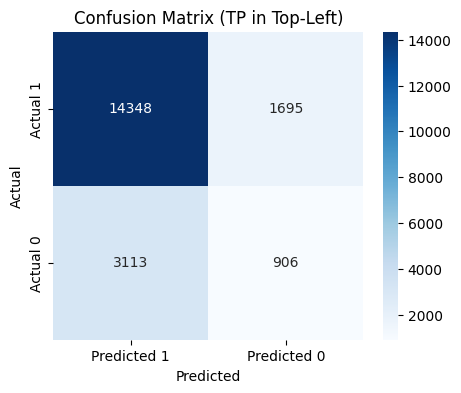

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm_reordered = np.array([[cm[1, 1], cm[1, 0]], [cm[0, 1], cm[0, 0]]])

# Visualize the rearranged confusion matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_reordered, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 1', 'Predicted 0'], yticklabels=['Actual 1', 'Actual 0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (TP in Top-Left)')
plt.show()

In [96]:
accuracy

0.7603429368956236

In [121]:
preprocessed_df.head()

,StudedntId,AcademicYear,Semester,CourseId,CourseName,CourseCollege,Score,College,Type,Grade,Introduction
0,1115,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,81.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
1,1108,18-19,1.0,146,Advanced Mathematics (B) (1),National School of Development,79.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
2,1192,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,89.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
3,1193,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,74.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...
4,1293,19-20,1.0,146,Advanced Mathematics (B) (1),National School of Development,89.0,National School of Development,Required major,5.0,Explanation: Comparing with the introductions ...


In [122]:
grouped_counts = preprocessed_df.groupby('StudedntId').size().reset_index(name='Count').sort_values('Count', ascending=False)

In [123]:
grouped_counts.describe()

,StudedntId,Count
count,4546.000000,4546.000000
mean,2275.278927,32.401232
std,1315.214148,18.275331
min,1.000000,1.000000
25%,1137.250000,24.250000
50%,2273.500000,29.000000
75%,3409.750000,45.000000
max,4568.000000,96.000000


In [124]:
grouped_counts = preprocessed_df.groupby('CourseId').size().reset_index(name='Count').sort_values('Count', ascending=False)

In [125]:
grouped_counts.describe()

,CourseId,Count
count,3551.000000,3551.000000
mean,2662.389186,41.480146
std,1516.965770,150.611006
min,2.000000,1.000000
25%,1358.500000,3.000000
50%,2704.000000,7.000000
75%,3781.500000,26.000000
max,5591.000000,3513.000000
